In [2]:
import maup # mggg's library for proration, see documentation here: https://github.com/mggg/maup
import pandas as pd # standard python data library
import geopandas as gp # the geo-version of pandas
import numpy as np 
from statistics import mean, median
from pandas import read_csv

**Load datasets**

In [3]:
#Load VTD shapefile
#NOTE: This has all the relevant data from the MGGG file except for '12 Presidential & '16 Election results, demographic data

vtds=gp.read_file("./raw-from-files/R2016_Assignment_Layers.gdb")

#Load Block-VTD Key File to Aggregate Demographic Data to the VTD Level

block_keys=pd.read_csv("./raw-from-files/Block_Level_GeoKeys.tab",sep="\t",engine='python')

#MGGG Assigns districts from 2011, 2016 enacted plans
#MGGG also lists a judge plan, but that file was not available and not neccessary to validate (see report) 

newplan= gp.read_file('./raw-from-files/2016_shp/2016_Contingent_Congressional_Plan_Corrected.shp')

oldplan=gp.read_file('./raw-from-files/2011_shp/Rucho_Lewis_Congress_3.shp')

#MGGG's File (Loading now to perform a quick check that the vtd shapefile is the correct one)

final_mggg=gp.read_file('./raw-from-files/NC_VTD/NC_VTD.shp')

#2012 Election Data 
election_data_2012_sort=pd.read_csv("./raw-from-files/results_sort_20121106.txt",engine='python')

#2016 Election Data 
#Column names are needed for the file to load
col_names = ["col1", "col2", "col3", "col4", "col5", "col6"]
election_data_2016_sort=pd.read_csv("./raw-from-files/results_sort_20161108.txt",names=col_names,error_bad_lines=False,sep='\t',engine='python')

**Check to Make Sure VTD Shapefile is the Right One**

In [4]:
final_mggg["geometry"]=final_mggg.buffer(0)
vtds["geometry"]=vtds.buffer(0)
proj = vtds.crs
final_mggg = final_mggg.to_crs(proj)
file = vtds.difference(final_mggg)

#Difference as a percentage is very very close to 0
print(sum(file.area)/sum(vtds.area))

#To 6 decimal places, the two files are equal 
print(final_mggg.geom_almost_equals(vtds,decimal=6).unique())

5.959530413906318e-12
[ True]


**Take a Look at VTD File as well as MGGG File to see what is present / missing**

In [5]:
print(vtds.columns)
print(final_mggg.columns)

Index(['ALAND10', 'AWATER10', 'VTD', 'County', 'VTD_Key', 'VTD_Code',
       'VTD_Name', 'PL10AA_TOT', 'PL10VA_TOT', 'EL08G_AG_D', 'EL08G_AG_R',
       'EL08G_AG_TOT', 'EL08G_AD_D', 'EL08G_AD_R', 'EL08G_AD_TOT',
       'EL08G_CA_D', 'EL08G_CA_R', 'EL08G_CA_TOT', 'EL08G_CI_D', 'EL08G_CI_R',
       'EL08G_CI_L', 'EL08G_CI_W', 'EL08G_CI_TOT', 'EL08G_CL_D', 'EL08G_CL_R',
       'EL08G_CL_TOT', 'EL08G_GV_D', 'EL08G_GV_R', 'EL08G_GV_L',
       'EL08G_GV_TOT', 'EL08G_LG_D', 'EL08G_LG_R', 'EL08G_LG_L',
       'EL08G_LG_TOT', 'EL08G_SPI_D', 'EL08G_SPI_R', 'EL08G_SPI_TOT',
       'EL08G_USS_D', 'EL08G_USS_R', 'EL08G_USS_L', 'EL08G_USS_W',
       'EL08G_USS_TOT', 'EL10G_USS_D', 'EL10G_USS_R', 'EL10G_USS_L',
       'EL10G_USS_W', 'EL10G_USS_TOT', 'EL12G_GV_D', 'EL12G_GV_R',
       'EL12G_GV_L', 'EL12G_GV_W1', 'EL12G_GV_W2', 'EL12G_GV_TOT',
       'EL12G_LG_D', 'EL12G_LG_R', 'EL12G_LG_TOT', 'EL12G_AD_D', 'EL12G_AD_R',
       'EL12G_AD_TOT', 'EL12G_CA_D', 'EL12G_CA_R', 'EL12G_CA_TOT',
       'EL12G_

**Rename and Clean Columns in VTD File to match MGGG**

In [6]:
#Renaming the 2008 Election Data
vtds = vtds.rename(columns={"EL08G_GV_TOT": "EL08G_GV_T","EL08G_USS_D": "EL08G_USS_","EL08G_USS_R": "EL08G_US_1","EL08G_USS_L": "EL08G_US_2","EL08G_USS_W": "EL08G_US_3","EL08G_USS_TOT": "EL08G_US_4"})

#Renaming the 2010 Election Data
vtds = vtds.rename(columns={"EL10G_USS_D": "EL10G_USS_","EL10G_USS_R": "EL10G_US_1","EL10G_USS_L": "EL10G_US_2","EL10G_USS_W": "EL10G_US_3","EL10G_USS_TOT": "EL10G_US_4"})

#Renaming the 2012 Election Data Columns to match MGGG-NC
vtds = vtds.rename(columns={"EL12G_GV_W1": "EL12G_GV_W","EL12G_GV_W2": "EL12G_GV_1","EL12G_GV_TOT": "EL12G_GV_T"})

#Renaming the 2014 Election Data
vtds = vtds.rename(columns={"EL14G_USS_R": "EL14G_USS_","EL14G_USS_D": "EL14G_US_1","EL14G_USS_L": "EL14G_US_2","EL14G_USS_WI": "EL14G_US_3","EL14G_USS_TOT": "EL14G_US_4"})

#Rename shapefile data
vtds = vtds.rename(columns={"Shape_Length":"Shape_Leng"})

In [7]:
print(vtds.columns)

Index(['ALAND10', 'AWATER10', 'VTD', 'County', 'VTD_Key', 'VTD_Code',
       'VTD_Name', 'PL10AA_TOT', 'PL10VA_TOT', 'EL08G_AG_D', 'EL08G_AG_R',
       'EL08G_AG_TOT', 'EL08G_AD_D', 'EL08G_AD_R', 'EL08G_AD_TOT',
       'EL08G_CA_D', 'EL08G_CA_R', 'EL08G_CA_TOT', 'EL08G_CI_D', 'EL08G_CI_R',
       'EL08G_CI_L', 'EL08G_CI_W', 'EL08G_CI_TOT', 'EL08G_CL_D', 'EL08G_CL_R',
       'EL08G_CL_TOT', 'EL08G_GV_D', 'EL08G_GV_R', 'EL08G_GV_L', 'EL08G_GV_T',
       'EL08G_LG_D', 'EL08G_LG_R', 'EL08G_LG_L', 'EL08G_LG_TOT', 'EL08G_SPI_D',
       'EL08G_SPI_R', 'EL08G_SPI_TOT', 'EL08G_USS_', 'EL08G_US_1',
       'EL08G_US_2', 'EL08G_US_3', 'EL08G_US_4', 'EL10G_USS_', 'EL10G_US_1',
       'EL10G_US_2', 'EL10G_US_3', 'EL10G_US_4', 'EL12G_GV_D', 'EL12G_GV_R',
       'EL12G_GV_L', 'EL12G_GV_W', 'EL12G_GV_1', 'EL12G_GV_T', 'EL12G_LG_D',
       'EL12G_LG_R', 'EL12G_LG_TOT', 'EL12G_AD_D', 'EL12G_AD_R',
       'EL12G_AD_TOT', 'EL12G_CA_D', 'EL12G_CA_R', 'EL12G_CA_TOT',
       'EL12G_CI_D', 'EL12G_CI_R', 'EL12G

In [8]:
vtds = vtds[['ALAND10', 'AWATER10', 'VTD', 'County', 'VTD_Key', 'VTD_Name',
       'PL10AA_TOT', 'PL10VA_TOT', 'EL08G_GV_D', 'EL08G_GV_R', 'EL08G_GV_L',
       'EL08G_GV_T', 'EL08G_USS_', 'EL08G_US_1', 'EL08G_US_2', 'EL08G_US_3',
       'EL08G_US_4', 'EL10G_USS_', 'EL10G_US_1', 'EL10G_US_2', 'EL10G_US_3',
       'EL10G_US_4', 'EL12G_GV_D', 'EL12G_GV_R', 'EL12G_GV_L', 'EL12G_GV_W',
       'EL12G_GV_1', 'EL12G_GV_T', 'EL14G_USS_', 'EL14G_US_1', 'EL14G_US_2',
       'EL14G_US_3', 'EL14G_US_4', 'Shape_Leng', 'Shape_Area','geometry']]

Remaining work: Add in demographic data, district assignments from 2 plans and add '12 presidential and '16 results.

**Load Census API**

Retrieve demographic data from Census API

To see the full list of census variables, look here: https://api.census.gov/data/2010/dec/sf1/variables.html

In [9]:
# Code chunk by Melisande Teng - VRDI 2019
variables = [
    # pop
    "P005001",
    "P005003",
    "P005004",
    "P005005",
    "P005006",
    "P005007",
    "P005008",
    "P005009",
    "P005010",
    "P005011",
    "P005012",
    "P005013",
    "P005014",
    "P005015",
    "P005016",
    "P005017",
    # vap
    "P011001",
    "P011002",
    "P011005",
    "P011006",
    "P011007",
    "P011008",
    "P011009",
    "P011010",
    "P011011",
]

keys = [
    # pop
    "TOTPOP",  # these follow from above, so TOTPOP = P005001
    "NH_WHITE",
    "NH_BLACK",
    "NH_AMIN",
    "NH_ASIAN",
    "NH_NHPI",
    "NH_OTHER",
    "NH_2MORE",
    "HISP",
    "H_WHITE",
    "H_BLACK",
    "H_AMIN",
    "H_ASIAN",
    "H_NHPI",
    "H_OTHER",
    "H_2MORE",
    # vap
    "VAP",
    "HVAP",
    "WVAP",
    "BVAP",
    "AMINVAP",
    "ASIANVAP",
    "NHPIVAP",
    "OTHERVAP",
    "2MOREVAP",
]

import requests

def counties(state_fips):
    """Inputs: state fips code
    Process: Retrieves a list of counties in the given state from the Census API.  
    Outputs: A list of county fips codes in the state. """
    resp = requests.get(
        "https://api.census.gov/data/2010/dec/sf1"
        "?get=NAME&for=county:*&in=state:{}".format(state_fips)
    )
    header, *rows = resp.json()
    county_column_index = header.index("county")
    county_fips_codes = set(row[county_column_index] for row in rows)
    return county_fips_codes


def block_data_for_county(state_fips, county_fips, variables=variables, keys=keys):
    """Inputs: state fips code, county fips code, list of variables and corresponding keys. 
    Process: formats the query to call the Census API. 
    Outputs: data for the county in a pandas dataframe. """
    url = (
        "https://api.census.gov/data/2010/dec/sf1"
        + "?get={},NAME&for=block:*".format(",".join(variables))
        + "&in=state:{}&in=county:{}&in=tract:*".format(state_fips, county_fips)
    )
    resp = requests.get(url)
    header, *rows = resp.json()
    variable_lookup = dict(zip(variables, keys))
    columns = [variable_lookup.get(column_name, column_name) for column_name in header]
    dtypes = {key: int for key in keys}
    dtypes.update({key: str for key in ["state", "county", "tract", "block"]})
    data = pd.DataFrame.from_records(rows, columns=columns).astype(dtypes)
    data["geoid"] = data["state"] + data["county"] + data["tract"] + data["block"]
    return data


def block_data_for_state(state_fips):
    """Input: state_fips
    Process: Retrieve a list of county fips codes in the state. 
        The Census API only lets you query one county at a time, so you first need the full list. 
        Then call block_data_for_county() to retrieve the data at the county level. 
    Outputs: block-level data for the state fips for the list of variables defined above. 
    """
    from tqdm.auto import tqdm
    county_fips_codes = counties(state_fips)
    return pd.concat(
        [
            block_data_for_county(state_fips, county_fips)
            for county_fips in tqdm(county_fips_codes)
        ]
    )

In [10]:
#if running script for the first time, use this chunk
nc = block_data_for_state('37')
nc = nc.rename(columns={"geoid": "GEOID10"})
nc.to_csv('nc_census_2010_blocks2.csv')

Example of how you would write the census data to a csv and then re-load it so you don't have to query it every time you re-run this script


In [ ]:
#nc = pd.read_csv('./nc_census_2010_blocks2.csv')
#nc = nc.astype({"GEOID10": str})

Take a look at the census data

Variables that aren't aren't added (BPOP and nBPOP) can be calculated from the data (Will see that this calculation is the same as the one the census performs)

In [11]:
nc["BPOP"]=nc["NH_BLACK"]+nc["H_BLACK"]
nc["nBPOP"]=nc["TOTPOP"]-nc["NH_BLACK"]-nc["H_BLACK"]

**Merge Demographic and Voting Population Data with Block_Keys**

Using Block Keys because that was the method MGGG specified. 

In [12]:
#Number of rows match
print(block_keys.shape)
print(nc.shape)

#Change GEOID10 to Block_Key as that is what we will merge on
nc = nc.rename(columns={"GEOID10": "Block_Key"})


(288987, 17)
(288987, 33)


Convert both "Block_Key" columns to integers so they can be joined

In [13]:
nc["Block_Key"]=nc["Block_Key"].astype(int)
block_keys["Block_Key"]=block_keys["Block_Key"].astype(int)

In [14]:
block_joined=pd.merge(nc,block_keys,on='Block_Key',how='outer',indicator=True)

In [15]:
#Both files originally had 288,987 rows, new one has the same
print(block_joined.shape)

#Next step will be to use the VTD_Key value to pivot data to the VTD level to match MGGG

(288987, 50)


**Pivot Block Level Census Data to VTD Level by VTD Key**

In [16]:
census_vtd=pd.pivot_table(block_joined,index="VTD_Key",aggfunc=sum)
census_vtd.reset_index(inplace=True)

**Check to make sure that VTD row number makes sense**

In [17]:
#Both the VTD shapefile and the census data at the VTD level have 2,692 rows
print(census_vtd.shape)
print(vtds.shape)

(2692, 40)
(2692, 36)


**Filter Census VTD File Columns**

In [18]:
census_vtd.columns

Index(['VTD_Key', '2MOREVAP', 'AMINVAP', 'ASIANVAP', 'BG_Code', 'BG_Key',
       'BPOP', 'BVAP', 'Block_Code', 'Block_Key', 'Cnty_Code', 'Cnty_Key',
       'HISP', 'HVAP', 'H_2MORE', 'H_AMIN', 'H_ASIAN', 'H_BLACK', 'H_NHPI',
       'H_OTHER', 'H_WHITE', 'NHPIVAP', 'NH_2MORE', 'NH_AMIN', 'NH_ASIAN',
       'NH_BLACK', 'NH_NHPI', 'NH_OTHER', 'NH_WHITE', 'OTHERVAP', 'Place_Code',
       'Place_Key', 'TOTPOP', 'Tract_Code', 'Tract_Key', 'Tract_Name', 'VAP',
       'WVAP', 'ZCTA5', 'nBPOP'],
      dtype='object')

In [19]:
column_List = ['VTD_Key','BPOP','nBPOP','TOTPOP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN','NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'HISP', 'H_WHITE','H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP','HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP','2MOREVAP']
census_vtd=census_vtd[column_List]

**Merge Census VTD Data with the VTD Shapefile by "VTD Key"**

In [20]:
vtds_joined = pd.merge(census_vtd,vtds,on='VTD_Key',how='outer',indicator=True)

**Check to make sure that joined VTD row number makes sense**

In [21]:
#Joined file has the same number of rows as the two original files
print(vtds_joined.shape)

(2692, 64)


**Next Step: Tie VTDs to their District Assignment Across the 2 Plans**

MGGG Assigns districts from 2011, 2016, and new judge enacted plan 
Taken from NCLEG Congressional Districts Shapefile

"newplan" is the 2016 plan  
"oldplan" is the 2011 plan  
"judge" is the new judge plan - not being validated here, see report for explanation why

**Set Shapefile Projections**

In [22]:
vtds_joined = gp.GeoDataFrame(vtds_joined, geometry='geometry')
vtds_joined["geometry"]=vtds_joined.buffer(0)
proj=vtds_joined.crs

***2016 plan - "newplan"***

In [23]:
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
#print(newplan)
newplan=newplan.to_crs(proj)
newplan["geometry"] = newplan.buffer(0)
assignments=maup.assign(vtds_joined,newplan)
assignments=assignments+1
#There are 13 Congressional Districts in North Carolina, but there are no 0 districts, 
#We have to add 1.0 to each districts because Python indexing starts at 0.
vtds_joined["newplan"]=assignments

**2011 plan - "oldplan"**

In [24]:
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
#print(oldplan)
oldplan=oldplan.to_crs(proj)
oldplan["geometry"] = oldplan.buffer(0)
assignments=maup.assign(vtds_joined,oldplan)
assignments=assignments+1
#There are 13 Congressional Districts in North Carolina, but there are no 0 districts, 
#We have to add 1.0 to each districts because Python indexing starts at 0.
vtds_joined["oldplan"]=assignments

**'12 Presidential and '16 election replication**

Note: Ultimately, we are able to replicate all of the '12 presidential data and most of the '16 election data

In [25]:
#create dictionary of state + county fips

my_county= {
    'ALAMANCE':'37001', 'ALEXANDER':'37003','ALLEGHANY':'37005','ANSON':'37007','ASHE':'37009', 'AVERY':'37011', 'BEAUFORT':'37013', 'BERTIE':'37015', 'BLADEN':'37017',  'BRUNSWICK':'37019',
    'BUNCOMBE':'37021','BURKE':'37023','CABARRUS':'37025','CALDWELL':'37027','CAMDEN':'37029','CARTERET':'37031','CASWELL':'37033','CATAWBA':'37035','CHATHAM':'37037','CHEROKEE':'37039','CHOWAN':'37041','CLAY':'37043','CLEVELAND':'37045',
    'COLUMBUS':'37047','CRAVEN':'37049','CUMBERLAND':'37051','CURRITUCK':'37053','DARE':'37055','DAVIDSON':'37057','DAVIE':'37059','DUPLIN':'37061','DURHAM':'37063','EDGECOMBE':'37065',
    'FORSYTH':'37067','FRANKLIN':'37069','GASTON':'37071','GATES':'37073','GRAHAM':'37075','GRANVILLE':'37077',
    'GREENE':'37079','GUILFORD':'37081','HALIFAX':'37083','HARNETT':'37085','HAYWOOD':'37087','HENDERSON':'37089','HERTFORD':'37091','HOKE':'37093','HYDE':'37095',
    'IREDELL':'37097','JACKSON':'37099','JOHNSTON':'37101','JONES':'37103','LEE':'37105','LENOIR':'37107','LINCOLN':'37109','MCDOWELL':'37111','MACON':'37113','MADISON':'37115',
    'MARTIN':'37117','MECKLENBURG':'37119','MITCHELL':'37121','MONTGOMERY':'37123','MOORE':'37125','NASH':'37127','NEW HANOVER':'37129','NORTHAMPTON':'37131','ONSLOW':'37133','ORANGE':'37135','PAMLICO':'37137','PASQUOTANK':'37139','PENDER':'37141','PERQUIMANS':'37143','PERSON':'37145','PITT':'37147','POLK':'37149','RANDOLPH':'37151',
    'RICHMOND':'37153','ROBESON':'37155','ROCKINGHAM':'37157','ROWAN':'37159','RUTHERFORD':'37161','SAMPSON':'37163','SCOTLAND':'37165','STANLY':'37167','STOKES':'37169','SURRY':'37171','SWAIN':'37173','TRANSYLVANIA':'37175','TYRRELL':'37177','UNION':'37179','VANCE':'37181','WAKE':'37183','WARREN':'37185','WASHINGTON':'37187','WATAUGA':'37189','WAYNE':'37191','WILKES':'37193','WILSON':'37195','YADKIN':'37197',  'YANCEY':'37199'
}

In [27]:

#filtering the 2012 data to just the presidential race
office_list_2012=["PRESIDENT AND VICE PRESIDENT OF THE UNITED STATES"]
election_data_2012_sort=election_data_2012_sort[election_data_2012_sort['contest'].isin(office_list_2012)]

#As mentioned in the report, the NC VTD vote reporting removes countywide election results
print("Before removing countywide results, the precinct level results have a difference of " + str(abs(election_data_2012_sort['total votes'].sum()-final_mggg['EL12G_PR_T'].sum())))
countywide_VTD = ["ONE STOP","ABSENTEE BY MAIL","TRANSFER","ACCUMULATED","PROVISIONAL","CURBSIDE"]
election_data_2012_sort = election_data_2012_sort[~election_data_2012_sort.vtd.isin(countywide_VTD)]
print("After removing countywide results, the precinct level results have a difference of " + str(abs(election_data_2012_sort['total votes'].sum()-final_mggg['EL12G_PR_T'].sum())))

Before removing countywide results, the precinct level results have a difference of 0
After removing countywide results, the precinct level results have a difference of 0


In [28]:
election_data_2012_sort['state_county_id']=election_data_2012_sort['county'].map(my_county)

In [31]:
#Create a VTD Key column and pivot off of that value
election_data_2012_sort['VTD_Key']=election_data_2012_sort['state_county_id']+election_data_2012_sort['vtd']
pivoted_2012 = pd.pivot_table(election_data_2012_sort, values=['total votes'], index=["VTD_Key"],columns=["choice"])
pivoted_2012.columns = pivoted_2012.columns.droplevel(0)


In [32]:
pivoted_2012.head()
pivoted_2012.columns = ["EL12G_PR_L","EL12G_PR_D","EL12G_PR_R","EL12G_PR_W","EL12G_PR_1"]
pivoted_2012.index.names = ["VTD_Key"]
pivoted_2012["EL12G_PR_T"] = pivoted_2012["EL12G_PR_L"]+pivoted_2012["EL12G_PR_D"]+pivoted_2012["EL12G_PR_R"]+pivoted_2012["EL12G_PR_W"]+pivoted_2012["EL12G_PR_1"]

pivoted_2012.reset_index(drop=True)
pivoted_2012.head()
pivoted_2012 = pivoted_2012.reset_index()

In [34]:
#Check to make sure it looks like how we want it
print(pivoted_2012.head())

    VTD_Key  EL12G_PR_L  EL12G_PR_D  EL12G_PR_R  EL12G_PR_W  EL12G_PR_1  \
0   3700101          16         488        1661           1           6   
1   3700102          32         429        1936           0           4   
2  37001035          19         832        1437           0           3   
3  3700103C          19         526        1318           0           2   
4  3700103N          25        1143        1618           0           6   

   EL12G_PR_T  
0        2172  
1        2401  
2        2291  
3        1865  
4        2792  


In [35]:
vtds_joined = vtds_joined.drop(["_merge"],axis=1)
print(vtds_joined.head())

    VTD_Key  BPOP  nBPOP  TOTPOP  NH_WHITE  NH_BLACK  NH_AMIN  NH_ASIAN  \
0   3700101   309   4560    4869      4332       309       10        20   
1   3700102   104   4387    4491      4250       103       19        12   
2  37001035   514   5932    6446      5522       503       24        66   
3  3700103C   207   2607    2814      2399       207        1        90   
4  3700103N   426   5286    5712      4983       424        3       101   

   NH_NHPI  NH_OTHER  ...  EL14G_USS_  EL14G_US_1  EL14G_US_2  EL14G_US_3  \
0        1         5  ...        1071         295          71           0   
1        0         1  ...        1246         313          62           2   
2        0        11  ...         920         434          43           3   
3        0         5  ...         943         455          44           6   
4        3         5  ...        1063         853          53           3   

   EL14G_US_4    Shape_Leng    Shape_Area  \
0        1437  46279.877623  1.314280e+08

In [36]:
#From diving into the VTD names, we figured out these needed to be changed, the first is a typo and the rest are changing zeroes to match
election_2012_VTD_changes = {
    "37061CYCK":"37061CYRK",
    "3716501":"371651",
    "3716502":"371652",
    "3716503":"371653",
    "3716504":"371654",
    "3716505":"371655",
    "3716506":"371656",
    "3716507":"371657",
    "3716508":"371658",
    "3716509":"371659",
    
    "371771":"3717701",
    "371772":"3717702",
    "371773":"3717703",
    
    "37185001":"371851",
    "37185002":"371852",
    "37185003":"371853",
    "37185004":"371854",
    "37185005":"371855",
    "37185006":"371856",
    "37185007":"371857",
    "37185008":"371858",
    "37185009":"371859",
    "37185010":"3718510",
    "37185011":"3718511",
    "37185012":"3718512",
    "37185013":"3718513",
    "37185014":"3718514"
}

pivoted_2012['VTD_Key'] = pivoted_2012['VTD_Key'].map(election_2012_VTD_changes).fillna(pivoted_2012['VTD_Key'])
print(pivoted_2012.head())

    VTD_Key  EL12G_PR_L  EL12G_PR_D  EL12G_PR_R  EL12G_PR_W  EL12G_PR_1  \
0   3700101          16         488        1661           1           6   
1   3700102          32         429        1936           0           4   
2  37001035          19         832        1437           0           3   
3  3700103C          19         526        1318           0           2   
4  3700103N          25        1143        1618           0           6   

   EL12G_PR_T  
0        2172  
1        2401  
2        2291  
3        1865  
4        2792  


In [37]:
#Check to make sure the number of rows makes sense
print(pivoted_2012.shape)
print(vtds_joined.shape)

(2692, 7)
(2692, 65)


In [38]:
#Join the '12 election results with the other VTD file and check new shape (should be 2692 if all match)
vtds_joined = pd.merge(vtds_joined,pivoted_2012,on=['VTD_Key','VTD_Key'],how='outer',indicator=True)
print(vtds_joined.shape)

(2692, 72)


**2016 Data**

In [39]:
#Clean up the data and rename the columns
election_data_2016_sort = election_data_2016_sort.iloc[1:]
election_data_2016 = election_data_2016_sort.reset_index(inplace=True)
election_data_2016_sort.columns = ["county_id","county_desc","precinct_id","precinct_desc","contest_name","vote_for","candidate","votes"]

In [40]:
#Filter out irrelevant races and create a VTD_Key field using the precinct name column
office_list_2016=["US PRESIDENT","US SENATE","NC GOVERNOR"]
election_data_2016_sort=election_data_2016_sort[election_data_2016_sort['contest_name'].isin(office_list_2016)]

election_data_2016_sort['state_county_id']=election_data_2016_sort['county_desc'].map(my_county)
election_data_2016_sort['VTD_Key']=election_data_2016_sort['state_county_id']+election_data_2016_sort['precinct_id']
print(election_data_2016_sort.head(10))

    county_id county_desc precinct_id precinct_desc  contest_name  vote_for  \
75          1    ALAMANCE          01     PATTERSON   NC GOVERNOR       1.0   
76          1    ALAMANCE          01     PATTERSON   NC GOVERNOR       1.0   
77          1    ALAMANCE          01     PATTERSON   NC GOVERNOR       1.0   
78          1    ALAMANCE          01     PATTERSON   NC GOVERNOR       1.0   
79          1    ALAMANCE          01     PATTERSON   NC GOVERNOR       1.0   
119         1    ALAMANCE          01     PATTERSON  US PRESIDENT       1.0   
120         1    ALAMANCE          01     PATTERSON  US PRESIDENT       1.0   
121         1    ALAMANCE          01     PATTERSON  US PRESIDENT       1.0   
122         1    ALAMANCE          01     PATTERSON  US PRESIDENT       1.0   
123         1    ALAMANCE          01     PATTERSON  US PRESIDENT       1.0   

           candidate   votes state_county_id  VTD_Key  
75         Lon Cecil    45.0           37001  3700101  
76        OVER VOT

In [41]:
#Pivot based off of the VTD Key column, change column names and add result totals columns
pivoted_2016 = pd.pivot_table(election_data_2016_sort, values=['votes'], index=["VTD_Key"],columns=["contest_name","candidate"])
pivoted_2016.columns = ["EL16G_GV_L","EL16G_GV_OVER","EL16G_GV_R","EL16G_GV_D","EL16G_GV_UNDER",
                       "EL16G_PR_R","EL16G_PR_L","EL16G_PR_D","EL16G_PR_OVER","EL16G_PR_UNDER","EL16G_PR_W",
                       "EL16G_US_1","EL16G_US_OVER","EL16G_USS_","EL16G_US_2","EL16G_US_UNDER"]
pivoted_2016 = pivoted_2016.drop(["EL16G_GV_OVER","EL16G_GV_UNDER","EL16G_PR_OVER","EL16G_PR_UNDER","EL16G_US_OVER","EL16G_US_UNDER"],axis=1)
pivoted_2016["EL16G_PR_T"]=pivoted_2016["EL16G_PR_R"]+pivoted_2016["EL16G_PR_L"]+pivoted_2016["EL16G_PR_D"]+pivoted_2016["EL16G_PR_W"]
pivoted_2016["EL16G_GV_T"]=pivoted_2016["EL16G_GV_L"]+pivoted_2016["EL16G_GV_R"]+pivoted_2016["EL16G_GV_D"]
pivoted_2016["EL16G_US_3"]=pivoted_2016["EL16G_US_1"]+pivoted_2016["EL16G_US_2"]+pivoted_2016["EL16G_USS_"]

In [42]:
#Reset index to make VTD_Key a column
pivoted_2016 = pivoted_2016.reset_index()
print(pivoted_2016.head())

    VTD_Key  EL16G_GV_L  EL16G_GV_R  EL16G_GV_D  EL16G_PR_R  EL16G_PR_L  \
0   3700101        45.0      1806.0       499.0      1865.0        50.0   
1   3700102        39.0      1927.0       497.0      2004.0        40.0   
2  37001035        52.0      1446.0      1060.0      1485.0        77.0   
3  3700103C        35.0      1072.0       748.0      1059.0        64.0   
4  3700103N        36.0      1146.0      1101.0      1160.0        66.0   

   EL16G_PR_D  EL16G_PR_W  EL16G_US_1  EL16G_USS_  EL16G_US_2  EL16G_PR_T  \
0       411.0        25.0       418.0      1829.0        89.0      2351.0   
1       403.0        24.0       396.0      1973.0        79.0      2471.0   
2       995.0        27.0       926.0      1532.0        96.0      2584.0   
3       679.0        33.0       597.0      1194.0        57.0      1835.0   
4      1036.0        35.0       956.0      1239.0        81.0      2297.0   

   EL16G_GV_T  EL16G_US_3  
0      2350.0      2336.0  
1      2463.0      2448.0  
2 

Code block below is to look into the VTD Keys that don't match: In total, 2,296 match

In [44]:
#Doing a merge to look into how many VTD_Keys from the '16 results match the VTD file
vtds_joined = vtds_joined.drop(["_merge"],axis=1)
vtds_2016_election = pd.merge(vtds_joined,pivoted_2016,on=['VTD_Key'],how='outer',indicator=True)
nc_official_vtds = vtds_2016_election[vtds_2016_election["_merge"]=="left_only"]["VTD_Key"]
election_vtds = vtds_2016_election[vtds_2016_election["_merge"]=="right_only"]["VTD_Key"]
matched_vtds = vtds_2016_election[vtds_2016_election["_merge"]=="both"]["VTD_Key"]

print("There are " + str(nc_official_vtds.count()) + " VTD Keys that only appear in the NC VTD file")
print("There are " + str(election_vtds.count()) + " VTD Keys that only appear in the '16 election file")
print("There are " + str(matched_vtds.count()) + " VTD Keys that were matched between the two files")

matched_vtds = pd.Series(matched_vtds)
matched_vtds.to_csv("./matched_vtds")

nc_official_vtds = pd.Series(nc_official_vtds)
nc_official_vtds.to_csv("./nc_16_official_vtds.csv")

election_vtds = pd.Series(election_vtds)
election_vtds.to_csv("./election_16_vtds.csv")

KeyError: "['_merge'] not found in axis"

In [45]:
print(vtds_joined.shape)
print(pivoted_2016.shape)

(2692, 71)
(2695, 14)


In [46]:
#Because not all of the VTDs match, this is only a left join
vtds_joined = pd.merge(vtds_joined,pivoted_2016,on=['VTD_Key'],how='left',indicator=False)

In [48]:
print(vtds_joined.shape)

(2692, 84)


**Look at MGGG FINAL FILE (loaded above)**

In [49]:
final_mggg.head(2)

,ALAND10,AWATER10,VTD,County,VTD_Key,VTD_Name,PL10AA_TOT,PL10VA_TOT,EL08G_GV_D,EL08G_GV_R,...,VAP,HVAP,WVAP,BVAP,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,geometry
0,1951716.0,32157.0,3700106W,37001,3700106W,06W,1973,1505,330,301,...,1505,211,899,338,4,32,0,0,21,"POLYGON ((572318.656 259054.912, 572364.420 25..."
1,2887286.0,0.0,3700112E,37001,3700112E,12E,3391,2503,586,263,...,2503,622,1085,712,19,38,0,2,25,"POLYGON ((572318.656 259054.912, 572310.834 25..."


In [50]:
final_mggg.shape
print(final_mggg.columns.tolist())
column_Order = final_mggg.columns.tolist()

['ALAND10', 'AWATER10', 'VTD', 'County', 'VTD_Key', 'VTD_Name', 'PL10AA_TOT', 'PL10VA_TOT', 'EL08G_GV_D', 'EL08G_GV_R', 'EL08G_GV_L', 'EL08G_GV_T', 'EL08G_USS_', 'EL08G_US_1', 'EL08G_US_2', 'EL08G_US_3', 'EL08G_US_4', 'EL10G_USS_', 'EL10G_US_1', 'EL10G_US_2', 'EL10G_US_3', 'EL10G_US_4', 'EL12G_GV_D', 'EL12G_GV_R', 'EL12G_GV_L', 'EL12G_GV_W', 'EL12G_GV_1', 'EL12G_GV_T', 'EL14G_USS_', 'EL14G_US_1', 'EL14G_US_2', 'EL14G_US_3', 'EL14G_US_4', 'Shape_Leng', 'Shape_Area', 'EL12G_PR_D', 'EL12G_PR_R', 'EL12G_PR_L', 'EL12G_PR_W', 'EL12G_PR_1', 'EL12G_PR_T', 'EL16G_PR_R', 'EL16G_PR_D', 'EL16G_PR_L', 'EL16G_PR_W', 'EL16G_PR_T', 'EL16G_USS_', 'EL16G_US_1', 'EL16G_US_2', 'EL16G_US_3', 'EL16G_GV_D', 'EL16G_GV_R', 'EL16G_GV_L', 'EL16G_GV_T', 'BPOP', 'nBPOP', 'judge', 'newplan', 'oldplan', 'TOTPOP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'HISP', 'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP',

**Validation**

In [51]:
validate=pd.merge(vtds_joined,final_mggg, on=['VTD_Key'],how='inner')

In [52]:
#rows before and after are the same
print(validate.shape)
print(final_mggg.shape)

(2692, 168)
(2692, 85)


**Validate Demo Data and Elections**

In [53]:
#Column List should just be a list of columns to be compared with quantitative values
#Validating the various columns found in both

def validater(df,column_List):
    for i in column_List:
        left_Data = i + "_x"
        right_Data = i + "_y"
        if(sum(df[left_Data]-df[right_Data]) != 0):
            print("For " + i + " total difference is: " + str(sum(df[left_Data]-df[right_Data])))
        
validater(validate,['ALAND10', 'AWATER10', 'PL10AA_TOT', 'PL10VA_TOT', 'EL08G_GV_D', 'EL08G_GV_R', 'EL08G_GV_L', 'EL08G_GV_T', 'EL08G_USS_', 'EL08G_US_1', 'EL08G_US_2', 'EL08G_US_3', 'EL08G_US_4', 'EL10G_USS_', 'EL10G_US_1', 'EL10G_US_2', 'EL10G_US_3', 'EL10G_US_4', 'EL12G_GV_D', 'EL12G_GV_R', 'EL12G_GV_L', 'EL12G_GV_W', 'EL12G_GV_1', 'EL12G_GV_T', 'EL14G_USS_', 'EL14G_US_1', 'EL14G_US_2', 'EL14G_US_3', 'EL14G_US_4', 'Shape_Leng', 'Shape_Area','BPOP', 'nBPOP', 'newplan', 'oldplan', 'TOTPOP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'HISP', 'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP','EL12G_PR_D', 'EL12G_PR_R', 'EL12G_PR_L', 'EL12G_PR_W', 'EL12G_PR_1', 'EL12G_PR_T', 'EL16G_PR_R', 'EL16G_PR_D', 'EL16G_PR_L', 'EL16G_PR_W', 'EL16G_PR_T', 'EL16G_USS_', 'EL16G_US_1', 'EL16G_US_2', 'EL16G_US_3', 'EL16G_GV_D', 'EL16G_GV_R', 'EL16G_GV_L', 'EL16G_GV_T',])       


For newplan total difference is: 2785.0
For oldplan total difference is: -788991.0
For EL16G_PR_R total difference is: nan
For EL16G_PR_D total difference is: nan
For EL16G_PR_L total difference is: nan
For EL16G_PR_W total difference is: nan
For EL16G_PR_T total difference is: nan
For EL16G_USS_ total difference is: nan
For EL16G_US_1 total difference is: nan
For EL16G_US_2 total difference is: nan
For EL16G_US_3 total difference is: nan
For EL16G_GV_D total difference is: nan
For EL16G_GV_R total difference is: nan
For EL16G_GV_L total difference is: nan
For EL16G_GV_T total difference is: nan


Looks like there may be an issue with the plans and the 2016 data (which is expected given all VTD Keys didn't match)

**Check Enacted Plans**

New Plan

AxesSubplot(0.125,0.275331;0.775x0.454339)
AxesSubplot(0.125,0.275331;0.775x0.454339)


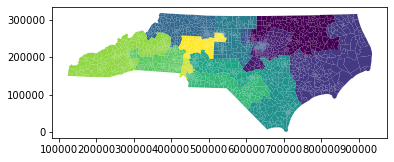

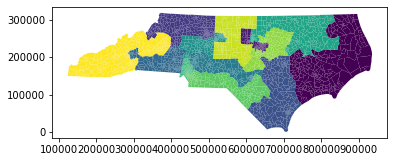

In [54]:
#The plans look the same when mapping them, so likely a numbering issue
print(vtds_joined.plot(column='newplan'))
print(final_mggg.plot(column='newplan'))

In [55]:
#Map the labels from one map to match the other to see if the underlying geographies are the same and just the labels are different
update_newplan= {11:6, 2:5,9:9,0:3,7:1,3:7, 4:10, 12:11,5:8,6:13,1:4,10:2,8:12}
validate['newplan_y_reindex']=validate['newplan_y'].map(update_newplan)
validate['newplan_diff_corrected']=validate.newplan_x-validate.newplan_y_reindex

#After matching the numberings, the plans match exactly
print(sum(validate['newplan_diff_corrected']))

0


Old Plan

AxesSubplot(0.125,0.275331;0.775x0.454339)
AxesSubplot(0.125,0.275331;0.775x0.454339)


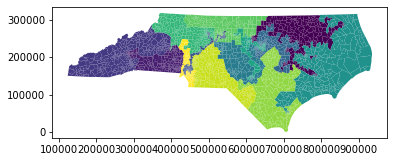

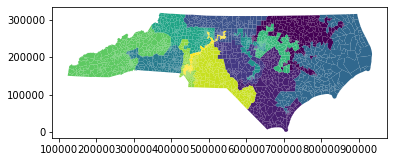

In [56]:
#The plans look the same when mapping them, so likely a numbering issue
print(vtds_joined.plot(column='oldplan'))
print(final_mggg.plot(column='oldplan'))

In [59]:
#MGGG's file using a 435 number labeling, where we used a 1-13 labeling
print(validate['oldplan_y'].unique())

#Map the labels from one map to match the other to see if the underlying geographies are the same and just the labels are different
update_oldplan= {296:6, 297:10,300:8,301:9, 305:12,303:3, 298:7, 294:1,295:11,299:2,306:4,302:5,304:13}
validate['oldplan_y_reindex']=validate['oldplan_y'].map(update_oldplan)
validate['oldplan_diff_corrected']=validate.oldplan_x-validate.oldplan_y_reindex

#After matching the numberings, the plans match exactly
print(sum(validate['oldplan_diff_corrected']))

[296. 297. 300. 301. 305. 303. 298. 294. 295. 299. 306. 302. 304.]
0


**Check 2016 Election Results**

In [60]:
#This function works are the NaN values present in the '16 results because of the mismatched VTD_Keys
#This functions create a new difference columns and prints out the difference values
def validater_nan(df,column_List):
    for i in column_List:
        left_Data = i + "_x"
        right_Data = i + "_y"
        diff_column = i + "_diff"
        print("For: ", i)
        print((validate[left_Data]-validate[right_Data]).value_counts())
        print("")
        validate[diff_column]=validate[left_Data]-validate[right_Data]
        
        
validater_nan(validate,['EL16G_PR_R', 'EL16G_PR_D', 'EL16G_PR_L', 'EL16G_PR_W', 'EL16G_PR_T', 'EL16G_USS_', 'EL16G_US_1', 'EL16G_US_2', 'EL16G_US_3', 'EL16G_GV_D', 'EL16G_GV_R', 'EL16G_GV_L', 'EL16G_GV_T',])


For:  EL16G_PR_R
 0.0      2288
-214.0       2
-485.0       1
-187.0       1
-21.0        1
-24.0        1
-1.0         1
 1.0         1
dtype: int64

For:  EL16G_PR_D
 0.0      2288
-167.0       1
-291.0       1
-305.0       1
-397.0       1
-310.0       1
-210.0       1
-1.0         1
 1.0         1
dtype: int64

For:  EL16G_PR_L
 0.0     2290
-7.0        1
-3.0        1
-18.0       1
-4.0        1
-6.0        1
-13.0       1
dtype: int64

For:  EL16G_PR_W
 0.0    2291
-2.0       2
-4.0       1
-1.0       1
-9.0       1
dtype: int64

For:  EL16G_PR_T
 0.0      2288
-389.0       1
-426.0       1
-236.0       1
-546.0       1
-808.0       1
-489.0       1
-2.0         1
 2.0         1
dtype: int64

For:  EL16G_USS_
 0.0      2288
-223.0       1
-243.0       1
-217.0       1
-28.0        1
-448.0       1
-30.0        1
-1.0         1
 1.0         1
dtype: int64

For:  EL16G_US_1
 0.0      2288
-151.0       1
-394.0       1
-323.0       1
-197.0       1
-265.0       1
-1.0         1
 1.0

In [61]:
#Overall, 2,288 of the 2,296 (see above) VTDs that match have values that match exactly

diff_list = 'EL16G_PR_R_diff','EL16G_PR_D_diff','EL16G_PR_L_diff','EL16G_PR_W_diff','EL16G_PR_T_diff', 'EL16G_USS__diff','EL16G_US_1_diff', 'EL16G_US_2_diff', 'EL16G_US_3_diff','EL16G_GV_D_diff', 'EL16G_GV_R_diff', 'EL16G_GV_L_diff','EL16G_GV_T_diff'

same_2016 = validate[(validate['EL16G_PR_R_diff']==0)&(validate['EL16G_PR_D_diff']==0)&
        (validate['EL16G_PR_L_diff']==0) &(validate['EL16G_PR_W_diff']==0)&
        (validate['EL16G_PR_T_diff']==0) &(validate['EL16G_USS__diff']==0)&
        (validate['EL16G_US_1_diff']==0) &(validate['EL16G_US_2_diff']==0)&
        (validate['EL16G_US_3_diff']==0) &(validate['EL16G_GV_D_diff']==0)&
        (validate['EL16G_GV_R_diff']==0) &(validate['EL16G_GV_L_diff']==0)&
        (validate['EL16G_GV_T_diff']==0)]
same_2016.count()


VTD_Key            2288
BPOP_x             2288
nBPOP_x            2288
TOTPOP_x           2288
NH_WHITE_x         2288
                   ... 
EL16G_US_3_diff    2288
EL16G_GV_D_diff    2288
EL16G_GV_R_diff    2288
EL16G_GV_L_diff    2288
EL16G_GV_T_diff    2288
Length: 186, dtype: int64